# Regularization Techniques

In in this notebook, I will purposely create a model which overfits and then apply regularization techniques to mitigate this overfitting as much as possible!

This is the goal:

<img src="early_stopping.png" alt="Early stopping" style="width: 500px;"/>

At the end of this notebook I create my own custom CallBack

In [1]:
import tensorflow as tf
import numpy as np 

In [2]:
#Load our dataset - Sklearns Diabetes as low number of data pts - so easier to create a model whihc will overfit

from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [20]:
# Get the input and target data

print(diabetes_dataset.keys(), end=2*'\n')
data = diabetes_dataset['data']
print(data.shape, type(data), end=2*'\n')
target = diabetes_dataset['target']
print(target.shape, type(target))

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])

(442, 10) <class 'numpy.ndarray'>

(442,) <class 'numpy.ndarray'>


In [4]:
#Data has already been centered and scaled (see desc) so lets Normalise - numpy arrays so have mean and std methods

targets = (target-target.mean()) / target.std()

In [5]:
# Partition the data into training and validation sets

from sklearn.model_selection import train_test_split 

train_data, val_data, train_targets, val_targets = train_test_split(data, targets, test_size=0.2) #splits into 80/20 
print(train_data.shape, train_targets.shape, end=2*'\n')
print(val_data.shape, val_targets.shape)

(353, 10) (353,)

(89, 10) (89,)


In [6]:
# Load the data into training and validation Dataset objects

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_targets))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_targets))

#also shuffle dataset - use 353 which is the size of the dataset - might as well as so small!

train_dataset = train_dataset.shuffle(353)

#now lets batch up our training data

train_dataset = train_dataset.batch(128)
val_dataset = val_dataset.batch(89)

#final stadge - prefeching - this is where tensor flow prefeches the next batch in parallel - optimises runtime!
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE) 

In [7]:
train_data.shape[-1]

10

In [8]:
# Build the MLP model - to build an mlp we need sequencial class

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


#NOTE TO SELF: we are telling tf what the input_shape is in (batch_size, input_shape)
# our input_shape is 10 since we have 353 examples of length 10
#we are not telling it anything about the batch_dim!! - it works it out based on
#the data we give it!

#consequently since tf now knows the input_shape it can create the weights automatically (calls the .build method).
#Since the weights have shape (input_shape, units) !!! - Brilliant!
model = Sequential([
    Dense(256, activation='relu', input_shape=(train_data.shape[-1],)), # note train_data which is narray not train_dataset
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 134,657
Trainable params: 134,657
Non-trainable params: 0
_________________________________________________________________


I've created a model which has 134,657 parameters for a training dataset with n=353 examples! This should definielty over fit!! As planned!

Lets see:

In [9]:
# Compile the model with neccessary optimizer and loss fn

model.compile(optimizer='adam', loss='mse')

In [10]:
# Train the model, including validation

#now fit the model
# earlier I created a tf.data.dataset object as a tuple of inputs and targets - so can just straight feed dataset object in!
#(similarly for validation - used to evaluate the loss and any model metrics at the end of each epoch. not used in training)

history = model.fit(train_dataset, epochs=100, validation_data=val_dataset, verbose=False) 

In [11]:
#we have two metrics, the loss on the training data and the loss on the validation set - both use mse as defined in compile
print(type(history.history), history.history.keys())

<class 'dict'> dict_keys(['loss', 'val_loss'])


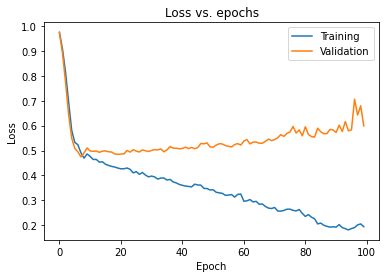

In [12]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

As predicited we have clear overfitting! as the model starts to learn (epochs get bigger) the training loss is decreasing, whilst the validation loss is sky rocketing. Therefore the model is overfitting the training data, but when it sees new (unseen) data, it doesnt generalise well as seen in the high loss on validation!

### Let's fix this through regularization!

First 'port of call' is to impliment l2 regularization into each Dense layer in the network and include enclosed dropout layers.

Both $\mathcal{l}^2$ and $\mathcal{l}^1$ regularisation can easily be included using the `kernel_regularizer` and `bias_regularizer` keyword arguments in the `Dense` layer.

In [13]:
# Redefine the model using l2 regularisation and dropout

from tensorflow.keras.layers import Dropout #import dropout layer
from tensorflow.keras import regularizers #import regularizers module

#set hyper parameters 
l2_coeff = 1e-5
rate = 0.5

#def function to build updated model

def get_regularised_model():
    
    model = Sequential([#added regularizer l2 norm
        Dense(256, kernel_regularizer=regularizers.l2(l2_coeff), activation='relu', input_shape=(train_data.shape[-1],)),
        Dropout(rate),  #add dropout 
        Dense(256, kernel_regularizer=regularizers.l2(l2_coeff), activation='relu'),
        Dropout(rate),  #add dropout 
        Dense(256, kernel_regularizer=regularizers.l2(l2_coeff), activation='relu'),
        Dropout(rate),
        Dense(1)
    ])
    return model

reg_model = get_regularised_model()
reg_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               2816      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [14]:
# Compile the model
reg_model.compile(optimizer='adam', loss='mse')

#fit the model
history = reg_model.fit(train_dataset, epochs=100, validation_data=val_dataset, verbose=False)

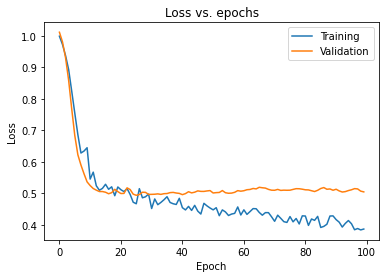

In [15]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

This is already a great improvement! We are seeing that the loss on the training data is far more realisic and the loss on the validation set is also far more realisitic! Its leveling out and not increasing further with the number of epochs.

Undoubtly, this is still showing signs of overfitting, but already the two regularization techniques ive applied have effectively started to tackle the problem!

lets continue with our quest and introduce `EarlyStopping` (which aims to break training once a patience threshold on no incremental improvemnets in the validation loss, is met). We do this through a callback!

The `EarlyStopping` callback is a built-in callback in the `tf.keras.callbacks` module. You can see a complete list of built-in callbacks [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks).

In [16]:
# Create a new model

reg_2_model = get_regularised_model()

#compile it
reg_2_model.compile(optimizer='adam', loss='mse')

In [17]:
# Create an EarlyStopping callback

#monitor: tells the callback which metric it should be measuring 
#patience: is the thershold/tolerance (ie the num of epochs that the performance is allowed to not improve on the best 
#performance, before training is terminated)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [18]:
#train the model - now with the callback in place

#NOTE: callbacks are passed as lists
history = reg_2_model.fit(train_dataset, epochs=100, validation_data=val_dataset, verbose=False,
                   callbacks=[earlystopping])

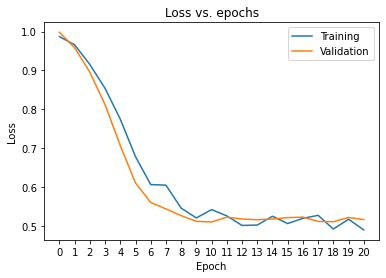

In [19]:
# Plot the training and validation metrics

import numpy as np

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history.history['loss'])))
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Here we see the best validation loss (lowest) was achieved on the tenth epoch as we have 10 epochs of tolerance (patience level). Here we are seeing no overfitting. The validation loss is remaining in line with the training loss. This implies the model generalises very well!

## Custom CallBack

I will create a custom callback which saves a checkpoint of the 'best' model (one with the lowest validation loss). To do this I will utalise the `tf.train.Checkpoint` and `tf.train.CheckpointManger` classes.

In [21]:
from tensorflow.keras.callbacks import Callback

class CheckpointCallback(Callback): 
    
    def __init__(self, directory):
        #inherit from tf.keras.callbacks.CallBack class
        super(CheckpointCallback, self).__init__()
        #create a directory to store optimum model 
        self.directory = directory
        #initalise best validation score at infinty
        self.best_val = tf.Variable(np.inf, trainable=False)
   
    #the set model we dont need - it is already defined in the base class
    
    # save a checkpoint of the model and store it!
    def on_train_begin(self, logs=None):
        #save/create checkpoint of model and weights using .Checkpoint
        self.ckpt = tf.train.Checkpoint(model=self.model)
        #use .CheckpointManager to manages multiple checkpoints (set to 3) by keeping some and deleting unneeded ones.
        self.manager = tf.train.CheckpointManager(self.ckpt, self.directory, max_to_keep=3)
        
    #At the end of each epoch compare the current validation loss against the best 
    #validation loss so far. If it is better save the current model
    def on_epoch_end(self, epoch, logs=None):
        #get the current validation loss
        val_mae = logs['val_mae']
        if val_mae < self.best_val:
            #update our best score to current score
            self.best_val.assign(val_mae)
            #save the model in our manager
            self.manager.save()
            print('saving best model at epoch {}'.format(epoch))

I will also include earlystopping call back (initalised earlier) because otherwise the printing will be too much!

In [23]:
ckpt_callback = CheckpointCallback('Model_ckpt')

In [26]:
model_with_CC = get_regularised_model()

#compile - lets also keep an eye on mae
model_with_CC.compile(optimizer='adam', loss='mse', metrics=['mae'])

#fit
history = model_with_CC.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[earlystopping, ckpt_callback], verbose=False)

saving best model at epoch 0
saving best model at epoch 1
saving best model at epoch 2
saving best model at epoch 3
saving best model at epoch 4
saving best model at epoch 5
saving best model at epoch 6
saving best model at epoch 7
saving best model at epoch 8
saving best model at epoch 9
saving best model at epoch 16
saving best model at epoch 17
saving best model at epoch 18
saving best model at epoch 27


In [28]:
!dir .\\model_ckpt

 Volume in drive C is Windows
 Volume Serial Number is 9819-EB53

 Directory of C:\Users\matth\Documents\IMPERIAL\Deep LEARNING\week-2-lecture-notes-msp120\model_ckpt

15/12/2021  12:29    <DIR>          .
15/12/2021  12:29    <DIR>          ..
15/12/2021  12:29               345 checkpoint
15/12/2021  12:29         1,619,998 ckpt-12.data-00000-of-00001
15/12/2021  12:29             2,146 ckpt-12.index
15/12/2021  12:29         1,619,998 ckpt-13.data-00000-of-00001
15/12/2021  12:29             2,146 ckpt-13.index
15/12/2021  12:29         1,619,998 ckpt-14.data-00000-of-00001
15/12/2021  12:29             2,146 ckpt-14.index
               7 File(s)      4,866,777 bytes
               2 Dir(s)  260,753,408,000 bytes free


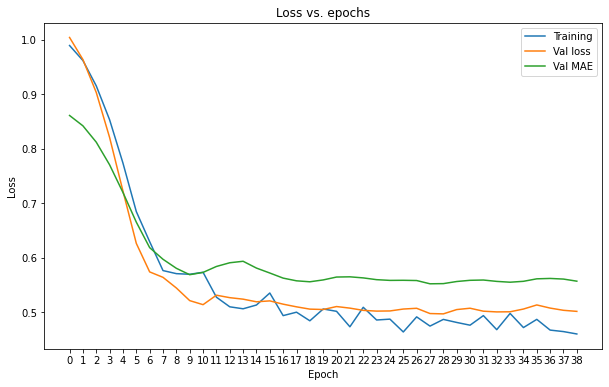

In [33]:
# Plot the training and validation metrics

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_mae'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history.history['loss'])))
plt.legend(['Training', 'Val loss', 'Val MAE'], loc='upper right')
plt.show()

Lets now restore the weights of the best saved model from disk! First create a re-initalised model, then we can restore our best model weights!

In [34]:
# Re-initialise the model

#this is a randomly initialised model 
model = get_regularised_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.evaluate(val_dataset)

#mse and mae are bad as we would expect

1/1 [==============================] - 0s 16ms/step - loss: 1.0293 - mae: 0.8709


[1.029290795326233, 0.8709493279457092]

In [47]:
# Restore the best model weights

#create a checkpoint with the model 
ckpt = tf.train.Checkpoint(model=model)
#restore the best model weights to this model
ckpt.restore(tf.train.latest_checkpoint('model_ckpt'))

#to show this has worked we re-evaluate it
model.evaluate(val_dataset)

#much better! same values as in the graph above!!

1/1 [==============================] - 0s 1ms/step - loss: 0.4973 - mae: 0.5520


[0.4973234236240387, 0.551971435546875]

In [48]:
# Clean up -remove the model file

!rd -r .\\model_ckpt

The system cannot find the file specified.
The directory is not empty.
